# An old FiPy solution to 1D BL
I'm not really sure if the result is correct.
The results is indeed incorrect. See the updated code a few cells below that might work slightly better.

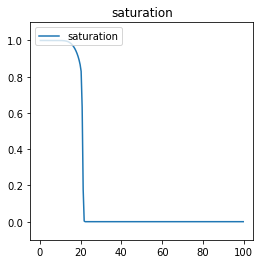

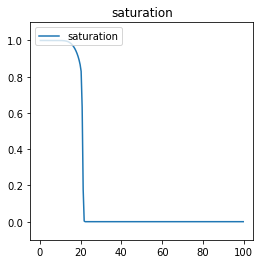

In [42]:
from fipy import *

u = 1.e-3
L = 100.
nx = 200
dt = 200.
dx = L/nx
muo = 0.002
muw = 0.001
mesh = Grid1D(dx = L/nx, nx = nx)
x = mesh.cellCenters
sw = CellVariable(mesh=mesh, name="saturation", hasOld=True, value = 0.)
sw.setValue(1,where = x<=dx)
sw.constrain(1.,mesh.facesLeft)
#sw.constrain(0., mesh.facesRight)
sw.faceGrad.constrain([0], mesh.facesRight)

eq = TransientTerm(coeff=1) + UpwindConvectionTerm(coeff = u
*(sw**2./muw)/(sw**2./muw+(1-sw)**2./muo) * [[1]]) == 0

sw.constrain(1.,mesh.facesLeft)
#sw.constrain(0., mesh.facesRight)
sw.faceGrad.constrain([0], mesh.facesRight)

steps = 100
viewer = Viewer(vars = sw, datamax=1.1, datamin=-0.1)
for step in range(steps):
    sw.updateOld()
    swres = 1.0e6
    while swres > 1e-5:
        swres = eq.sweep(dt = dt, var = sw)
        print(swres)
        
viewer.plot()

## Updates solution on October 8th, 2019

In [43]:
from fipy import *

# relperm parameters
swc = 0.1
sor = 0.1
krw0 = 0.3
kro0 = 1.0
nw = 2.0
no = 2.0

# domain and boundaries
k = 1e-12 # m^2
u = 1.e-3
L = 100.
nx = 100
dt = 800.
dx = L/nx

# fluid properties
muo = 0.002
muw = 0.001

# define the fractional flow functions
def krw(sw):
    res = krw0*((sw-swc)/(1-swc-sor))**nw
    return res

def dkrw(sw):
    res = krw0*nw/(1-swc-sor)*((sw-swc)/(1-swc-sor))**(nw-1)
    return res


def kro(sw):
    res = kro0*((1-sw-sor)/(1-swc-sor))**no
    return res

def dkro(sw):
    res = -kro0*no/(1-swc-sor)*((1-sw-sor)/(1-swc-sor))**(no-1)
    return res

def fw(sw):
    res = krw(sw)/muw/(krw(sw)/muw+kro(sw)/muo)
    return res

def dfw(sw):
    res = (dkrw(sw)/muw*kro(sw)/muo-krw(sw)/muw*dkro(sw)/muo)/(krw(sw)/muw+kro(sw)/muo)**2
    return res

import matplotlib.pyplot as plt
import numpy as np

sw_plot = np.linspace(swc, 1-sor, 50)

## Visualize the relative permeability and fractional flow curves

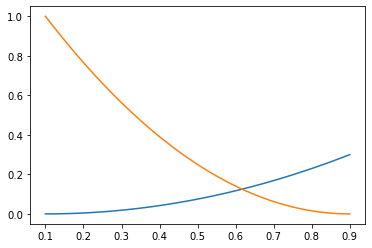

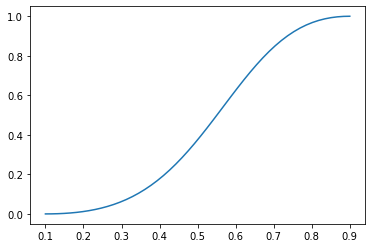

In [44]:
krw_plot = [krw(sw) for sw in sw_plot]
kro_plot = [kro(sw) for sw in sw_plot]
fw_plot = [fw(sw) for sw in sw_plot]

plt.figure(1)
plt.plot(sw_plot, krw_plot, sw_plot, kro_plot)
plt.show()

plt.figure(2)
plt.plot(sw_plot, fw_plot)
plt.show()

In [45]:
# create the grid
mesh = Grid1D(dx = L/nx, nx = nx)
x = mesh.cellCenters

# create the cell variables and boundary conditions
sw = CellVariable(mesh=mesh, name="saturation", hasOld=True, value = swc)
# sw.setValue(1,where = x<=dx)
sw.constrain(1-sor,mesh.facesLeft)
#sw.constrain(0., mesh.facesRight)
sw.faceGrad.constrain([0], mesh.facesRight)


## Equations
$$\varphi \frac{\partial S_w}{\partial t}+u \frac{\partial f_w}{\partial x}=0$$ or
$$\varphi \frac{\partial S_w}{\partial t}+\nabla.\left( u \frac{\partial f_w}{\partial S_w} S_w\right)+ \nabla. \left( u f_w-u\frac{\partial f_w}{\partial S_w} S_{w0} \right)=0$$

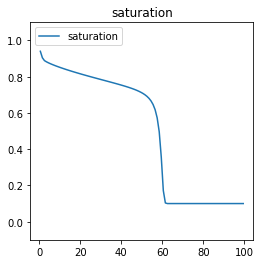

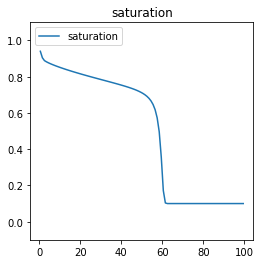

In [46]:

eq = TransientTerm(coeff=1) + UpwindConvectionTerm(coeff = u
*dfw(sw.faceValue)*[[1.0]]) + u*(fw(sw.faceValue)-dfw(sw.faceValue)*sw.faceValue).divergence == 0

sw.constrain(1.,mesh.facesLeft)
#sw.constrain(0., mesh.facesRight)
sw.faceGrad.constrain([0], mesh.facesRight)

steps = 50
viewer = Viewer(vars = sw, datamax=1.1, datamin=-0.1)
for step in range(steps):
    sw.updateOld()
    swres = 1.0e6
    while swres > 1e-5:
        swres = eq.sweep(dt = dt, var = sw)
#         print(swres)
        
viewer.plot()

## Analytical solution

In [47]:
import fractional_flow as ff
xt_shock, sw_shock, xt_prf, sw_prf, t, p_inj, R_oil = ff.frac_flow_wf(muw=muw, muo=muo, ut=u, phi=1.0, \
  k=1e-12, swc=swc, sor=sor, kro0=kro0, no=no, krw0=krw0, \
  nw=nw, sw0=swc, sw_inj=1.0, L=L, pv_inj=5.0)

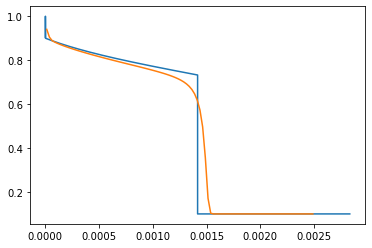

In [48]:
plt.figure()
plt.plot(xt_prf, sw_prf)
plt.plot(x.value.squeeze()/(steps*dt), sw.value)
plt.show()